In [3]:
import numpy as np


import numpy as np 
import matplotlib.pyplot as plt
import torch 
import ot 
import os

os.chdir(".")
cwd = os.getcwd()
import numba as nb

# import our gw, (bounded) pgw, mpgw 

from lib.gromov import gromov_wasserstein,cost_matrix_d,tensor_dot_param,tensor_dot_func,gwgrad_partial1,partial_gromov_wasserstein,partial_gromov_ver1,GW_dist,MPGW_dist,PGW_dist_with_penalty
from lib.gromov_barycenter import *
# import ugw 
from lib.opt import *
from lib.unbalanced_gromov_wasserstein.unbalancedgw.vanilla_ugw_solver import exp_ugw_sinkhorn,log_ugw_sinkhorn
from lib.unbalanced_gromov_wasserstein.unbalancedgw._vanilla_utils import ugw_cost
from lib.unbalanced_gromov_wasserstein.unbalancedgw.utils import generate_measure
from lib.unbalanced_gromov_wasserstein.unbalancedgw.batch_stable_ugw_solver import log_batch_ugw_sinkhorn

from ot.utils import dist, UndefinedParameter, list_to_array
from ot.optim import cg, line_search_armijo, solve_1d_linesearch_quad
from ot.utils import check_random_state, unif
from ot.backend import get_backend, NumpyBackend



from pathlib import Path

import numpy as np
import scipy as sp

from matplotlib import pyplot as plt
from sklearn import manifold
from sklearn.decomposition import PCA

from sklearn.datasets import load_digits
from sklearn.manifold import MDS




In [4]:
cwd

'/home/baly/projects/PGW_Metric'

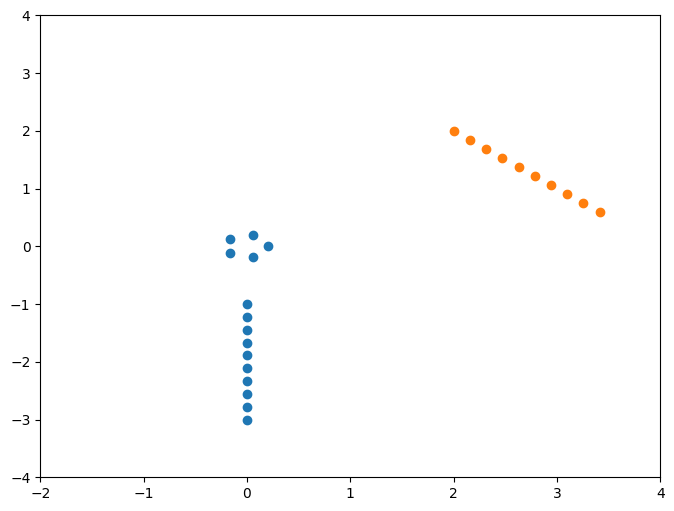

In [5]:
def circle_2d(num_points, radius=1, center=(0, 0)):
    """
    Generate points for a circle centered at the origin.

    Parameters:
    - num_points (int): Number of points on the circle
    - radius (float): Radius of the circle (default is 1)
    - center (tuple): (x, y) coordinates of the circle's center (default is (0, 0))

    Returns:
    - np.ndarray: Array of shape (num_points, 2), where each row is a point [x, y]
    """
    theta = np.linspace(0, 2 * np.pi, num_points, endpoint=False)  # Angles
    x = center[0] + radius * np.cos(theta)  # X coordinates
    y = center[1] + radius * np.sin(theta)  # Y coordinates
    return np.column_stack((x, y))  # Combine x and y into shape (num_points, 2)

import numpy as np

def line_2d(N, theta=0, length=2, initial_point=[0, 0]):
    """
    Generate points for a straight line.

    Parameters:
    - N (int): Number of points along the line
    - theta (float): Angle of the line in degrees (0° is horizontal)
    - length (float): Length of the line
    - initial_point (tuple): Starting point of the line (default is (0, 0))

    Returns:
    - np.ndarray: Array of shape (N, 2), where each row is a point [x, y]
    """

    x_start, y_start = initial_point[0],initial_point[1]
    x_end = x_start + length * np.cos(theta)
    y_end = y_start + length * np.sin(theta)

    x = np.linspace(x_start, x_end, N)
    y = np.linspace(y_start, y_end, N)

    return np.column_stack((x, y))


  # Combine x and y into shape (num_points, 2)



X=np.concatenate((line_2d(10,-np.pi/2,initial_point=[0,-1]),circle_2d(5,radius=0.2)))
Y=line_2d(10,-np.pi/4,initial_point=[2,2])

plt.figure(figsize=(8, 6))  # Set figure size
plt.scatter(X[:,0], X[:,1])  # Line plot with label and line width
plt.scatter(Y[:,0], Y[:,1])  # Line plot with label and line width
plt.xlim(-2, 4)  # Set x-axis limits
plt.ylim(-4, 4)  # Set y-axis limits
plt.show()



In [6]:
result={}
# OT method

C=cost_matrix_d(X,Y)
n,m=C.shape
p=np.ones(n)/m
q=np.ones(m)/m

C1=np.sqrt(cost_matrix_d(X,X))
C2=np.sqrt(cost_matrix_d(Y,Y))
max=C1.max()
C1/=max
C2/=max
G0=np.zeros((n,m))
G0[0:m,0:m]=np.eye(m)
result['ot']=ot.lp.emd(p/p.sum(),q/q.sum(),C)
result['pot']=opt_lp(p,q,C,Lambda=10.0)[0]
result['gw']=gromov_wasserstein(C1, C2, p/p.sum(), q/q.sum(), G0=G0,thres=1, numItermax=100*n, tol=1e-5,log=False, verbose=False,line_search=False)
result['pgw'] = partial_gromov_ver1(C1, C2, p, q, G0=G0, Lambda=1.0, thres=1, numItermax=100*n, tol=1e-5,log=False,verbose=False,line_search=False)






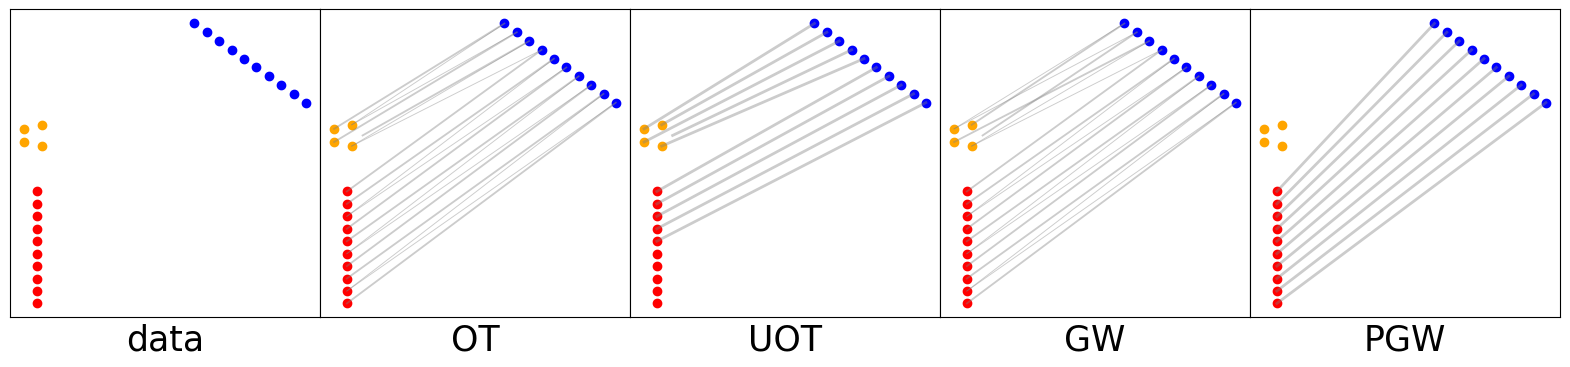

In [7]:
fig, axes = plt.subplots(1, 5, figsize=(4*5, 4))
threshold=1e-5
methods=['data','ot','pot','gw','pgw']
labels=['data','OT','UOT','GW','PGW']
N=10
for i, (method,ax) in enumerate(zip(methods,axes)):
    ax.scatter(X[0:N, 0], X[0:N, 1], c='r')
    ax.scatter(X[N+1:, 0],X[N+1:, 1], c='orange')
    ax.scatter(Y[:, 0], Y[:, 1], c='blue')
    ax.set_xticks([])  # Remove x-axis ticks
    ax.set_yticks([]) 

#    ax.set_xlim(-1, 6)  # Set x-axis limits
#    ax.set_ylim(-4, 3)  # Set y-axis limits
    if i>=1:
        gamma=result[method]
        for i1 in range(X.shape[0]):
            for j1 in range(Y.shape[0]):
                if gamma[i1, j1] > threshold:
                    ax.plot([X[i1, 0], Y[j1, 0]], [X[i1, 1], Y[j1, 1]], 'grey', lw=gamma[i1, j1]*20, alpha=0.4)
    ax.set_xlabel(labels[i],fontsize=25)
plt.subplots_adjust(wspace=0, hspace=0)
plt.savefig('toy_example/example.png', dpi=300, bbox_inches='tight')
plt.savefig('toy_example/example.pdf', dpi=300, bbox_inches='tight')

plt.show()

In [5]:
cwd

'/home/baly/projects'

In [64]:
X.shape

(15, 2)

In [65]:
Y.shape

(10, 2)